# Plot RS19 intro figures - Chapter 3

First plot:
 - First 14 days with full data (tide, T, U, C)

Second plot:
 - Extended basic version of plot 1 (line plots)
 - tide, m1, u, c

Third plot:
 - phase space with all events

In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from afloat.pca import PCA_2D, rotate_2D
import cmocean.cm as cm
from scipy.signal import find_peaks
from afloat.currents import sd_to_uv, uv_to_sd
from matplotlib.patches import Ellipse
from matplotlib.colors import to_rgba
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker


from wootils.plotnice import saveagu, basic_ts, vert_stack, plot_axislabels, plot_align, set_mirrorlim
import wootils.filters as fl
from wootils.plotcolours import coloured_line
from wootils.time_wutils import get_limidxs

import sys
sys.path.insert(0, '../')
from chp3_basefuncs import decompose_xarray, load_ntu, load_c
from chp3_fluxfuncs import get_nliw_times, get_solibore_times
from chp3_paperplots import add_symbols, draw_symbols, plot_one_endform
    
sns.set()
sns.set_style("white")
sns.set_style("ticks")
# Set the default tick length
plt.rcParams['xtick.major.size'] = 0
plt.rcParams['ytick.major.size'] = 0

pyODAS not found, not importing pIMOS.xrwrap.rsi_vmp


In [2]:
# Specify work locations
workDir = r'/mnt/c/Users/00099894/OneDrive - The University of Western Australia/UWA/PhD'
nc_dir = r'/mnt/c/Users/00099894/Large_Data/Experiments'

In [3]:
# Load depth data
ds_fname = os.path.join(workDir, 'data', 'field', 'KISSME2017', 'processed_data', 'GA_WEL_NWS_250m_DEM.nc')
ds = xr.open_dataset(ds_fname)
ds_topo = xr.DataArray(ds.topo.values.T, coords=[ds.X.values, ds.Y.values], dims=["X", "Y"])
# Crop to the region of interest
ds_topo = ds_topo.sel(X=slice(115.5, 121.5), Y=slice(-21, -16))

## Set the data file paths


In [4]:
fieldtrip = 'RS2019'
sig_fol = 'Signature'
mooring = 'L150'
yr = 2019

nc_file = '[RS2019]_[RS19_REC]_[T150]_[550]_[RDI 150 kHz Quartermaster]_[11795]_[no_outfile_append].nc'
temp_file = '[RS2019]_[RS19_REC]_[T150]_[multi(26)_nominal_instrument_height_asb]_[multi(2)_instrument_model]_[multi(26)_instrument_serial_number]_[no_outfile_append].nc'
m1_file = '[RS2019]_[RS19_REC]_[T150]_[multi(26)_nominal_instrument_height_asb]_[multi(2)_instrument_model]_[multi(26)_instrument_serial_number]_[no_outfile_append].nc'
m1_full = os.path.join(nc_dir, fieldtrip, 'pimos_v1.1.dev2', 'FV03', 'bmodes_noknockdown', m1_file)
moor = 'T150'

sig_file = 'SIG_meandataENU.nc'
sug_full = os.path.join('../0_identify_despike_save', sig_file)

In [5]:
wav_tx = get_nliw_times()
ev_wave = 3

In [6]:
wave_type = 'NLIW'
cb_short = ['$S_{obs}$', '$S_{est}$', '$S_{theory}$', '$\sigma_{obs}$', '$\sigma_{th}$']
df = pd.DataFrame(columns=cb_short)
spd_mean = []
spd_std = []
dir_mean = []
dir_std = []
int_dir = []
u_bt = []
v_bt = []
load_dir = os.path.join(nc_dir, fieldtrip, 'NLIW')

for ii, wt in enumerate(wav_tx):
    
    # Load fluxes
    sig_fil = f'{wave_type}_E{int(ii+1)}_fluxattrs.nc'
    vel_file = os.path.join(load_dir, sig_fil)
    if os.path.exists(vel_file):
        ds = xr.open_dataset(vel_file)
        xr.Dataset.close(ds)
        print(f'Loaded {sig_fil}')

        ## Extract the barotropic u,v

        # First highpass filter the m1 amp
        ds_tstep = np.median(np.diff(ds['time'].values)) / np.timedelta64(1, 'm')
        m1, nan_lx, nan_ex = fl.trim_edge_nans_xr(ds['mode_1'])
        m1_hp = xr.apply_ufunc(fl.filter1d, m1, 6, ds_tstep, 'highpass',\
                                input_core_dims=[['time'],[],[],[]], output_core_dims=[['time']],\
                                vectorize=True)
        
        # Select the first negative peak less than -18m
        px, pp = find_peaks(-ds['mode_1'][nan_lx:nan_ex].values, height=15, distance=100)
        ix_min = px[0]   #np.argmin(m1_hp.values)
        
        # Now get u,v at this time
        u_ix = ds['e_tide'][ix_min + nan_lx - 5:ix_min + nan_lx + 5].mean(dim='time').values
        v_ix = ds['n_tide'][ix_min + nan_lx - 5:ix_min + nan_lx + 5].mean(dim='time').values
        u_bt.append(u_ix)
        v_bt.append(v_ix)

        df.loc[ii, cb_short[0]] = ds.attrs['obs_celerity'][0]
        df.loc[ii, cb_short[3]] = ds.attrs['obs_celerity'][1]
        u_obs, v_obs = sd_to_uv(ds.attrs['obs_celerity'][0],\
                                ds.attrs['theta'][0],\
                                convention='ocean')
        spd_est, dir_est = uv_to_sd(u_obs - u_ix, v_obs - v_ix, convention='ocean')
        df.loc[ii, cb_short[1]] = spd_est

        df.loc[ii, cb_short[2]] = ds.attrs['m1_celerity'][0]
        df.loc[ii, cb_short[4]] = ds.attrs['m1_celerity'][0] - ds.attrs['m1_celerity'][1]

        ## Now get the speed and direction
        spd_mean.append(ds.attrs['obs_celerity'][0])
        spd_std.append(ds.attrs['obs_celerity'][1])
        dir_mean.append(ds.attrs['theta'][0])
        dir_std.append(ds.attrs['theta'][1])
        # int_dir.append(ds.attrs['heading'])

Loaded NLIW_E1_fluxattrs.nc
Loaded NLIW_E2_fluxattrs.nc
Loaded NLIW_E3_fluxattrs.nc
Loaded NLIW_E4_fluxattrs.nc
Loaded NLIW_E5_fluxattrs.nc
Loaded NLIW_E6_fluxattrs.nc
Loaded NLIW_E7_fluxattrs.nc
Loaded NLIW_E8_fluxattrs.nc
Loaded NLIW_E9_fluxattrs.nc
Loaded NLIW_E10_fluxattrs.nc
Loaded NLIW_E11_fluxattrs.nc


In [7]:
# Load the 2 ntu's
ntu_sn = ['0359_burstmedian', '2535_burstmedian']
ds_l_ntu = load_ntu(workDir, ntu_sn[0], mooring='L150')
ssc_good = (ds_l_ntu*2.62 - 4.38)/2.33
ssc_good = ssc_good.where(ssc_good > 0, 0)

# Load the pred tide
da_tide = xr.open_dataarray('IO_tide_T150.nc')

# Lood the mode-1 amp
ds_m1 = xr.open_dataset(m1_full)
m1 = ds_m1['A_n'].sel(modes=0)

### Plot the basemap template

In [8]:
tlim = [np.datetime64('2019-03-09T00:01'), np.datetime64('2019-03-21T00:00')]

Text(0, 0.5, 'C [g m$^{-3}$]')

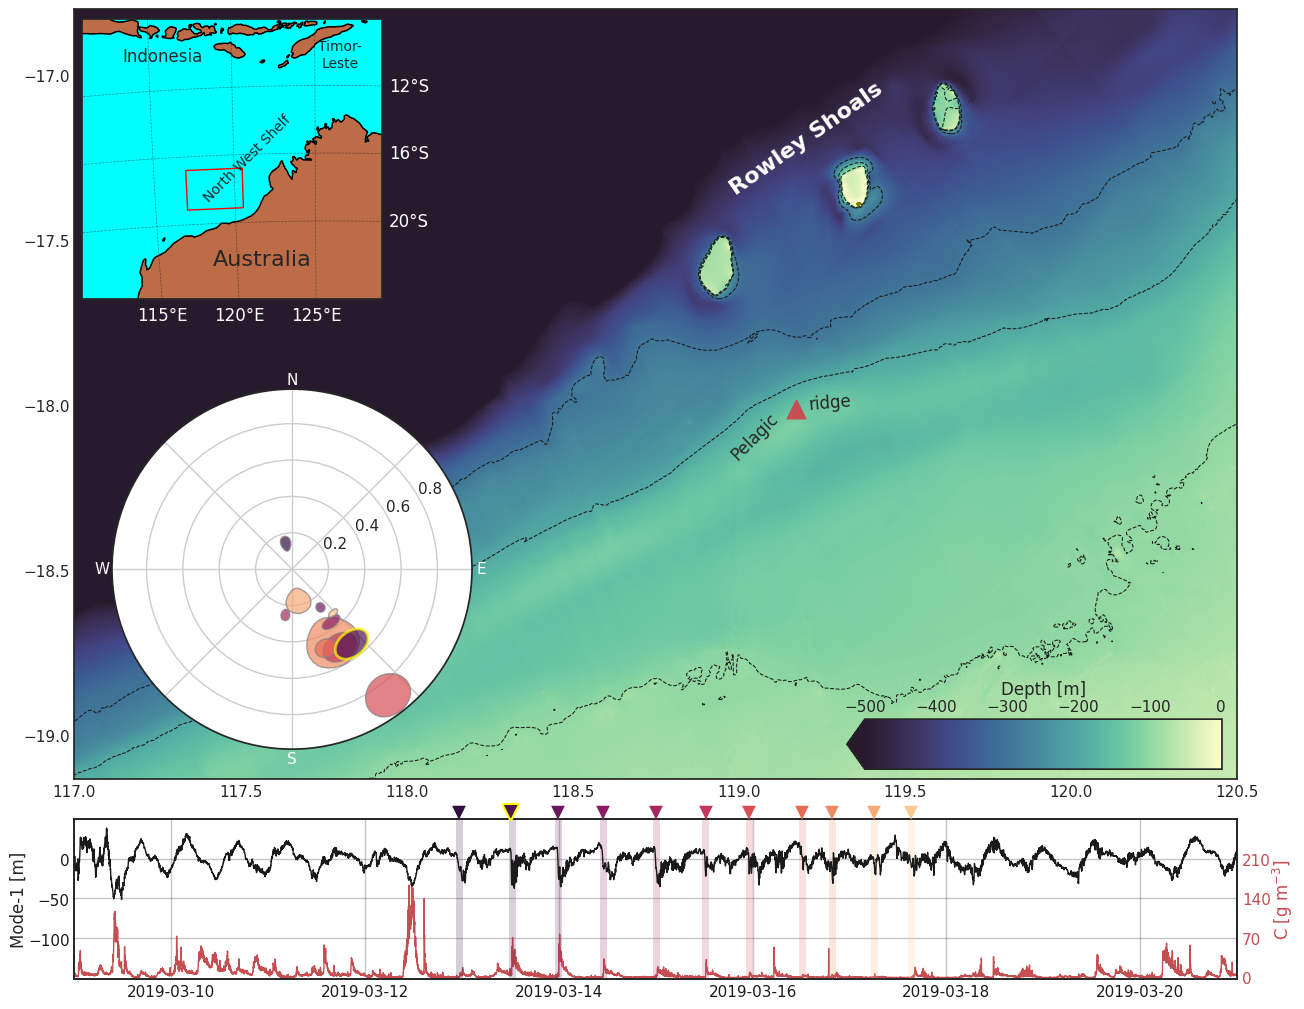

In [9]:
# Set main plot bounds
plt_ratio = 12/8
lon_dn, lon_up = 117, 120.5
lat_up = -16.8
lat_dn = lat_up - (lon_up-lon_dn)*(1/plt_ratio)
fsize = 15

# Plot the figure
fig, ax = vert_stack(1, hsize=fsize, vsize=fsize/plt_ratio)

# Draw main plot
xr_sig = xr.plot.imshow(ds_topo, 'X', 'Y', ax=ax, cmap=cm.deep_r,\
                        add_colorbar=False, vmax=1, vmin=-500, xlim=[lon_dn, lon_up], ylim=[lat_up, lat_dn])
cax = fig.add_axes([0.64, 0.12, 0.25, 0.05])
cb = plt.colorbar(xr_sig, cax=cax, orientation='horizontal', label='Depth [m]', extend='min')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')


xr_sigland = xr.plot.contourf(ds_topo, 'X', 'Y', levels=np.linspace(0, 10**6, 2), ax=ax, colors='olive',\
                          add_colorbar=False, extend='neither')
xr_sigland = xr.plot.contour(ds_topo, 'X', 'Y', levels=[-100, -200, -300], ax=ax,\
                             linestyles='--', linewidths=0.75, colors=['k'])

ax.set_xlabel('')
ax.set_ylabel('')

# Add some text
ax.text(0.63, 0.76, 'Rowley Shoals', transform=ax.transAxes, ha='center', fontsize=16,
        fontweight='bold', rotation=35, color='w')
ax.text(0.585, 0.415, 'Pelagic', transform=ax.transAxes, ha='center', fontsize=12,
        rotation=45)
ax.text(0.65, 0.48, 'ridge', transform=ax.transAxes, ha='center', fontsize=12,
        rotation=5)

# Add an inset plot showing the region
ax_inset = fig.add_axes([0.13, 0.58, 0.3/plt_ratio, 0.3],\
                        projection=ccrs.Orthographic(central_longitude=126, central_latitude=-20))
ax_inset.set_extent([111, 129, -24, -8], crs=ccrs.PlateCarree())

# add a map of coastlines
ax_inset.add_feature(cfeature.LAND, edgecolor='black', facecolor='xkcd:adobe')
ax_inset.add_feature(cfeature.OCEAN, facecolor='cyan')
ax_inset.add_feature(cfeature.COASTLINE)

# Add gridlines
gl = ax_inset.gridlines(draw_labels=True, linewidth=0.5, color='k', alpha=0.5, linestyle='--', zorder=10)
gl.xlocator = mticker.FixedLocator([115, 120, 125])
gl.ylocator = mticker.FixedLocator([-12, -16, -20])

gl.top_labels = False
gl.right_labels = True
gl.left_labels = False
gl.bottom_labels = True
gl.xlabel_style = {'color': 'w'}
gl.ylabel_style = {'color': 'w'}

# Add some text
ax_inset.text(0.6, 0.12, 'Australia', transform=ax_inset.transAxes, ha='center', fontsize=16)
ax_inset.text(0.55, 0.35, 'North West Shelf', transform=ax_inset.transAxes, ha='center', rotation=45, fontsize=10)
ax_inset.text(0.27, 0.85, 'Indonesia', transform=ax_inset.transAxes, ha='center')
ax_inset.text(0.86, 0.83, 'Timor-\nLeste', transform=ax_inset.transAxes, ha='center', fontsize=10)


# Highlight the main plot area on the inset map
rect = plt.Rectangle((lon_dn, lat_dn), lon_up-lon_dn, lat_up-lat_dn,
                     linewidth=1, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree())
ax_inset.add_patch(rect)

# Add key moorings
lb_lat = [-18.01059, -17.96941, -17.77761]
lb_lon = [119.1711, 119.12964, 118.98713]
km = ax.scatter(lb_lon[0], lb_lat[0], color='r', marker='^', s=180, zorder=11)

# Add a new axis
ax_rose = fig.add_axes([0.09, 0.14, 0.36, 0.36], projection='polar')
ax_rose.set_theta_zero_location("N")
ax_rose.set_theta_direction(-1)
ax_rose.tick_params(axis='both', which='major', pad=0)
col = cm.matter_r(np.linspace(0, 0.9, len(wav_tx)))
# Plot the ellipses with the largest dir_std at the back
z_ord = np.argsort(dir_std)[::-1]

for ii, (sm, ss, dm, ds, cc, u, v) in enumerate(zip(spd_mean, spd_std, dir_mean, dir_std, col, u_bt, v_bt)):
#     u_obs, v_obs = sd_to_uv(sm, dm, convention='ocean')
#     spd_est, dir_est = uv_to_sd(u_obs - u, v_obs - v, convention='ocean')
#     ellipse = Ellipse((dir_est, spd_est), 2*ds, 2*ss, color=cc, fill=True, lw=1, ec='grey', alpha=0.8)
#     ax_rose.add_patch(ellipse)    
    u_obs, v_obs = sd_to_uv(spd_mean[z_ord[ii]], dir_mean[z_ord[ii]], convention='ocean')
    spd_est, dir_est = uv_to_sd(u_obs - u, v_obs - v, convention='ocean')
    if z_ord[ii]==1:
        ellipse = Ellipse((dir_est, spd_est), 2*dir_std[z_ord[ii]], 2*spd_std[z_ord[ii]], color=col[z_ord[ii]], fill=True, lw=2, ec='yellow', alpha=0.7, zorder=20)
    else:
        ellipse = Ellipse((dir_est, spd_est), 2*dir_std[z_ord[ii]], 2*spd_std[z_ord[ii]], color=col[z_ord[ii]], fill=True, lw=1, ec='grey', alpha=0.7)
    ax_rose.add_patch(ellipse)  

ax_rose.set_ylim(0.0, 0.99)
ax_rose.set_xticklabels(['N', '', 'E', '', 'S', '', 'W', ''], color='w')
ax_rose.set_yticks(np.arange(0.2, 0.81, 0.2))
ax_rose.set_rlabel_position(60)
# yl = ax_rose.get_yticklabels()
# yl[-1] = ''
# ax_rose.set_yticklabels(yl)

# Add a new axis
old_pos = ax.get_position().bounds
new_pos = [old_pos[0], old_pos[1]-0.2, old_pos[2], 0.16]
ax_ts = fig.add_axes(new_pos)
# ax_ts = fig.add_axes([0.4, 0.69, 0.465, 0.17])

m1.plot(ax=ax_ts, color='k', lw=1, zorder=10)
# ax_ts.grid(zorder=0)

ax_sc = ax_ts.twinx()
(ssc_good).plot(ax=ax_sc, color='r', lw=1)
ax_sc.vlines(np.arange(np.datetime64('2019-03-10'), np.datetime64('2019-03-21'), np.timedelta64(2, 'D')), 0, 300, color='k', lw=1, alpha=0.25, zorder=1)
ax_sc.hlines([70, 140, 210], np.datetime64('2019-03-08'), np.datetime64('2019-03-21'), color='k', lw=1, alpha=0.25, zorder=1)
# ax_sc.grid(zorder=0)

ax_ts.set_zorder(ax_sc.get_zorder() + 1)
# ax_sc.set_zorder(ax_ts.get_zorder() + 1)

ax_ts.patch.set_visible(False)
ax_sc.patch.set_visible(False)

ax_ts.set_xlim(tlim)
ax_sc.set_xlim(tlim)
ax_ts.set_ylim(-149.9, 49.9)
ax_sc.set_ylim(-3, 279.9)
ax_sc.set_yticks([0, 70, 140, 210])

[add_symbols(wt, ax=ax_ts, c=cc, fs=20) for wt, cc in zip(wav_tx, col)]
add_symbols(wav_tx[1], ax=ax_ts, c=col[1], fs=20, ec='yellow')

# Add a vertical line in same color
[ax_ts.axvline(x=wt, color=cc, lw=5, alpha=0.2) for wt, cc in zip(wav_tx, col)]
ax_ts.set_xticks(np.arange(np.datetime64('2019-03-10'), np.datetime64('2019-03-21'), np.timedelta64(2, 'D')))
ax_ts.set_xticklabels(ax_ts.get_xticklabels(), color='k', rotation=0, ha='center')
ax_ts.set_yticklabels(ax_ts.get_yticklabels(), color='k')
ax_sc.set_yticklabels(ax_sc.get_yticklabels(), color='r')


ax_ts.set_title('')
ax_ts.set_xlabel('')
ax_ts.set_ylabel('Mode-1 [m]', labelpad=0)
ax_sc.set_ylabel('C [g m$^{-3}$]', labelpad=0, color='r')

In [10]:
saveagu('RS2019_map_F1v5', fig)